# Fit for $\alpha$ and $\epsilon$

In our latent variable model, we state that the radial mode frequencies are determined by the asymptotic relation ([Vrard et al. 2015](https://ui.adsabs.harvard.edu/abs/2015A%26A...579A..84V/abstract)) with some scatter: 

$\large\nu_{l=0} = (\bar{n} + \epsilon + (\frac{\alpha}{2}(\frac{\nu_{\rm max}}{\Delta\nu} - \epsilon - \bar{n})^2)) \Delta\nu$

where $\nu_{\rm l=0}$ is the frequency locations of all l=0 modes at overtones $\bar{n}$, $\epsilon$ is the phase offset, $\alpha$ determines the curvature, and $\Delta\nu$ is the large separation.

A bunch of these are free parameters in our model. We want to include prior information from the LEGACY and Kages samples when fitting our model, and we can do so by using the values for these hyperparameters derived from their data as the means on our prior distributions.

Some of these parameters (e.g. $\nu_{\rm max}$, $\Delta\nu$) are reported in the literature. The parameters specific to this asymptotic relation, $\epsilon$ and $\alpha$, are not. 

In order to obtain a quick measurement of these values, we'll run fit a model to the frequencies of each star, using only $\epsilon$ and $\alpha$ as free parameters.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz
import pandas as pd
import mystyle as ms
from astropy.io import ascii

In [3]:
mal = pd.read_csv('../../data/malatium.csv', index_col=0)

In [6]:
cop = pd.read_csv('../../data/copper.csv',index_col=0)
cop = cop[cop.l == 0] #We only want the radial modes

Lets test on a single target first...

In [24]:
kic = mal.KIC.values[0]

In [12]:
class model():
    def __init__(self, n, numax, deltanu):
        self.n = n
        self.numax = numax
        self.deltanu = deltanu
        
    def asymptotic(self, p):
        alpha, epsilon = p
        
        nmax = (self.numax / self.deltanu) - epsilon
        over = (n + epsilon + ((alpha/2)*(nmax - n)**2))
        return over * self.deltanu
    
    def __call__(self, p):
        return self.asymptotic(p)

In [32]:
n = cop.loc[cop.KIC == str(kic)].n.values
numax = mal.loc[mal.KIC == kic].numax.values
deltanu = mal.loc[mal.KIC == kic].dnu.values
l0s = cop.loc[cop.KIC == str(kic)].Freq.values
e_l0s = cop.loc[cop.KIC == str(kic)].e_Freq.values

In [33]:
mod = model(n, numax, deltanu)

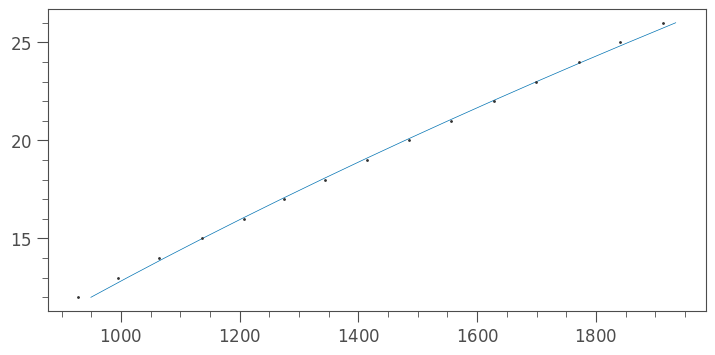

In [44]:
init = [.02,  #alpha
        1.]  #epsilon

with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    ax.errorbar(l0s, n, xerr=e_l0s, fmt='o')
    ax.plot(mod(init), n)

# Let's build the model

In [49]:
pm_model = pm.Model()
with pm_model:
    #Parameters
    alpha = pm.HalfNormal('alpha', sigma=1., testval=0.02)
    epsilon = pm.Normal('epsilon', mu=1., sigma=1., testval=1.)
    
    # Model
    fit = mod([alpha, epsilon])
    like = pm.Normal('like', mu=fit, sigma=e_l0s, observed=l0s)

In [57]:
init = 5000
with pm_model:
    trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:05<00:00, 3383.98draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1dd34af240>,
      dtype=object)

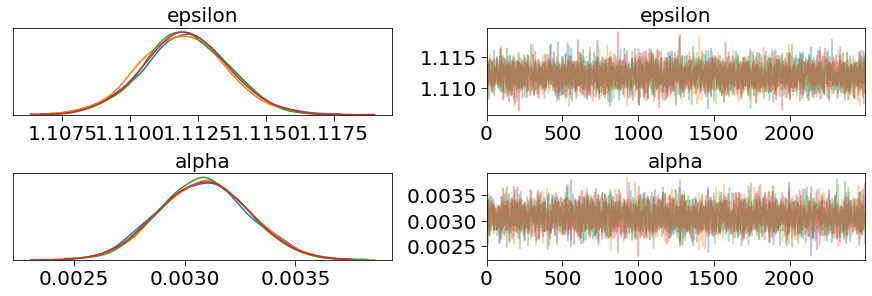

In [58]:
pm.traceplot(trace)

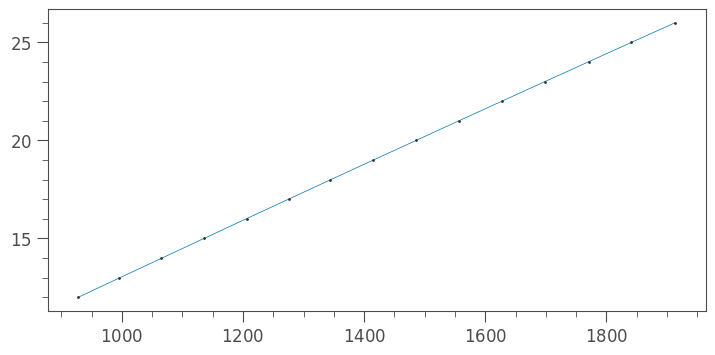

In [59]:
res = [np.median(trace[label]) for label in ['alpha','epsilon']]

with plt.style.context(ms.ms):
    fig, ax = plt.subplots()
    ax.errorbar(l0s, n, xerr=e_l0s, fmt='o')
    ax.plot(mod(res), n)

Lets just make this aligns with the literature value before continuing...

In [63]:
if not np.isclose(1.114, res[-1], atol=0.009):
    sys.exit()

Lets run on the whole sample! While we're at it, we're also going to store the small separations, but those will just be calculated averages.

In [69]:
cadmium = pd.DataFrame()
cadmium['KIC'] = mal.KIC.copy()
cadmium['alpha'] = np.nan
cadmium['e_alpha'] = np.nan
cadmium['epsilon'] = np.nan
cadmium['e_epsilon'] = np.nan
cadmium['d01'] = np.nan
cadmium['d02'] = np.nan
cadmium.head(1)

,KIC,alpha,e_alpha,epsilon,e_epsilon,d01,d02
0,1435467,NaN,NaN,NaN,NaN,NaN,NaN


INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:06<00:00, 2957.09draws/s]


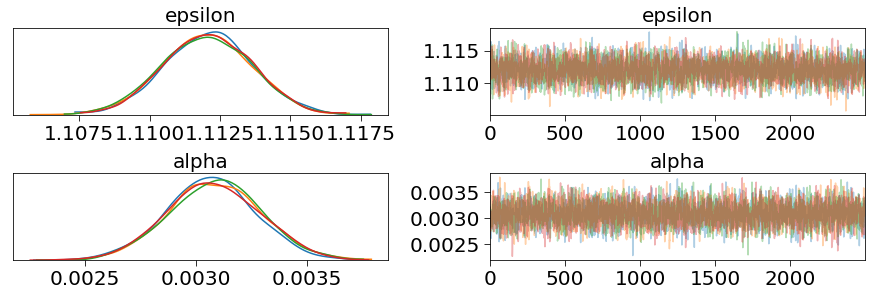

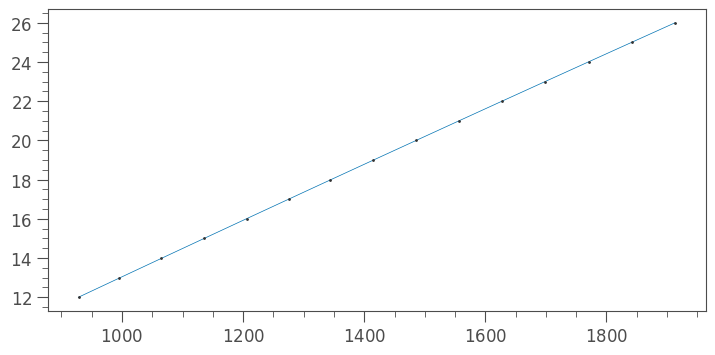

INFO:pymc3:Auto-assigning NUTS sampler...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:NUTS: [epsilon, alpha]
Sampling 4 chains: 100%|██████████| 20000/20000 [00:06<00:00, 3273.26draws/s]


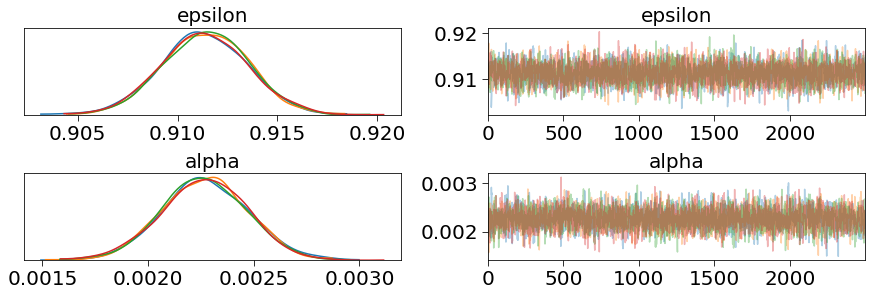

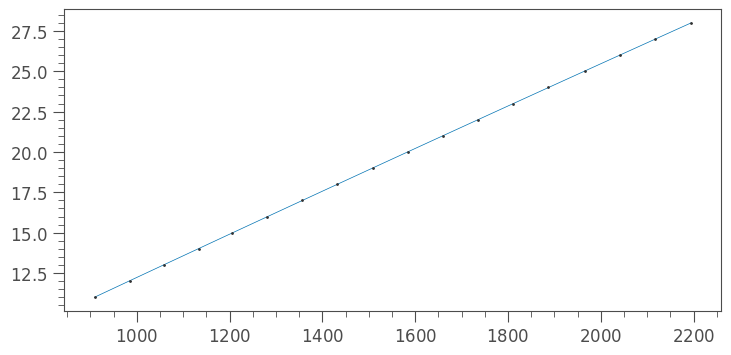

In [79]:
for kic in mal.KIC.values[0:2]:
    n = cop.loc[cop.KIC == str(kic)].n.values
    numax = mal.loc[mal.KIC == kic].numax.values
    deltanu = mal.loc[mal.KIC == kic].dnu.values
    l0s = cop.loc[cop.KIC == str(kic)].Freq.values
    e_l0s = cop.loc[cop.KIC == str(kic)].e_Freq.values    

    # Initiate the model
    mod = model(n, numax, deltanu)
    
    # Run the model
    init=5000
    pm_model = pm.Model()
    with pm_model:
        #Parameters
        alpha = pm.HalfNormal('alpha', sigma=1., testval=0.02)
        epsilon = pm.Normal('epsilon', mu=1., sigma=1., testval=1.)

        # Model
        fit = mod([alpha, epsilon])
        like = pm.Normal('like', mu=fit, sigma=e_l0s, observed=l0s)
        
        trace = pm.sample(chains=4, tune=int(init/2), draws=int(init/2))
    
    # Plot the output
    pm.traceplot(trace)
    plt.show()
    res = [np.median(trace[label]) for label in ['alpha','epsilon']]

    with plt.style.context(ms.ms):
        fig, ax = plt.subplots()
        ax.errorbar(l0s, n, xerr=e_l0s, fmt='o')
        ax.plot(mod(res), n)
        plt.show()
    
    # Add the output to the array
    cadmium.loc[cadmium.KIC==kic, 'alpha'] = np.median(trace['alpha'])
    cadmium.loc[cadmium.KIC==kic, 'e_alpha'] = np.std(trace['alpha'])
    cadmium.loc[cadmium.KIC==kic, 'epsilon'] = np.median(trace['epsilon'])
    cadmium.loc[cadmium.KIC==kic, 'e_epsilon'] = np.std(trace['epsilon'])
    
    cadmium.to_csv('../../data/cadmium.csv')